# Chương 2: Cơ sở và Chuẩn bị Dữ liệu (Data Preparation)

**Mục tiêu:** Chương này đóng vai trò là "nền móng". Chúng ta sẽ đi sâu vào quy trình xử lý dữ liệu thực tế - bước chiếm tới 80% thời gian của một dự án phân tích.

---

## 2.1. Dẫn nhập: Hiểm họa của dữ liệu "bẩn"

### Case Study: Thảm họa Marketing vì dữ liệu rác
Một Giám đốc Marketing của ngân hàng X muốn chạy mô hình dự báo khách hàng rời bỏ (Churn Prediction). Ông ta giao cho bạn file dữ liệu `customer_data.csv` gồm 5.000 dòng được trích xuất từ hệ thống CRM cũ.

Khi mở file ra, bạn thấy một mớ hỗn độn:
* Cột **Thu nhập** (Income) có 30% ô trống.
* Cột **Tuổi** (Age) có người là -5 tuổi, có người 200 tuổi.
* Cột **Điểm tín dụng** chứa cả số lẫn chữ "Chưa có".

Nếu bạn ném thẳng dữ liệu này vào mô hình chạy, kết quả sẽ hoàn toàn sai lệch (**Garbage In, Garbage Out**). Ví dụ: Mô hình có thể học sai rằng "người 200 tuổi có tỷ lệ rời bỏ thấp".

**Nhiệm vụ của chương này:** Biến đống dữ liệu hỗn độn đó thành "vàng" (Gold standard data) để sẵn sàng phân tích.

## 2.2. Cơ sở Lý thuyết về Làm sạch Dữ liệu

### 2.2.1. Dữ liệu khuyết (Missing Data)
Không phải ô trống nào cũng giống nhau. Chúng ta chia làm 3 loại:

1.  **MCAR (Missing Completely At Random):** Ngẫu nhiên hoàn toàn. Ví dụ: Nhân viên nhập liệu lỡ tay làm mất một trang hồ sơ. -> *Ít nguy hiểm, có thể xóa hoặc điền trung bình.*
2.  **MAR (Missing At Random):** Ngẫu nhiên có điều kiện. Ví dụ: Nữ giới thường ngại điền cân nặng hơn nam giới. Việc thiếu này phụ thuộc vào biến Giới tính. -> *Cần xử lý cẩn thận.*
3.  **MNAR (Missing Not At Random):** Không ngẫu nhiên (Nguy hiểm nhất). Ví dụ: Những người có thu nhập cực cao thường từ chối khai báo thu nhập. Nếu xóa những dòng này, mẫu của bạn sẽ bị lệch về phía người nghèo.

### 2.2.2. Giá trị ngoại lai (Outliers)
Outlier là những quan sát khác biệt quá mức so với phần còn lại.

* **Outlier đơn biến (Univariate):** Một giá trị cực đoan trên 1 cột (VD: Tuổi = 200).
* **Outlier đa biến (Multivariate):** Một tổ hợp giá trị bất thường (VD: Một người 20 tuổi nhưng có thu nhập 1 triệu USD/năm - từng cái riêng thì có thể, nhưng kết hợp lại thì rất nghi vấn). Chúng ta dùng khoảng cách **Mahalanobis** (đã học ở Chương 1) để phát hiện loại này.

### 2.2.3. Các giả định quan trọng (Assumptions)
Hầu hết các mô hình đa biến (Hồi quy, PCA, ANOVA) đều yêu cầu:
1.  **Tính chuẩn (Normality):** Dữ liệu phân phối hình chuông.
2.  **Tính tuyến tính (Linearity):** Mối quan hệ giữa các biến là đường thẳng.
3.  **Không đa cộng tuyến (No Multicollinearity):** Các biến độc lập không được sao chép lẫn nhau (VD: Đã có cột "Năm sinh" thì không cần cột "Tuổi").

## 2.3. Thực hành: Quy trình làm sạch dữ liệu trên Python

Chúng ta sẽ thực hiện quy trình **4 bước chuẩn**: 
1. Soi dữ liệu (EDA) 
2. Xử lý Missing 
3. Xử lý Outlier 
4. Kiểm tra chuẩn hóa.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- BƯỚC 0: TẠO DỮ LIỆU GIẢ LẬP (MÔ PHỎNG LỖI) ---
np.random.seed(42)
n_samples = 500

# Tạo dữ liệu chuẩn
data = {
    'CustomerID': range(1, n_samples + 1),
    'Age': np.random.normal(35, 10, n_samples).astype(int),
    'Income': np.random.normal(50000, 15000, n_samples),
    'CreditScore': np.random.randint(300, 850, n_samples)
}
df = pd.DataFrame(data)

# Cố tình tạo lỗi (Dirty Data Injection)
# 1. Tạo Missing Values (Income bị thiếu 10%)
df.loc[np.random.choice(df.index, 50, replace=False), 'Income'] = np.nan

# 2. Tạo Outliers (Tuổi = 200, Thu nhập cực khủng)
df.loc[0, 'Age'] = 200
df.loc[1, 'Age'] = -5
df.loc[2, 'Income'] = 1000000000  # Tỷ phú lạc vào

print("Dữ liệu thô ban đầu (5 dòng đầu):")
print(df.head())

Dữ liệu thô ban đầu (5 dòng đầu):
   CustomerID  Age        Income  CreditScore
0           1  200           NaN          727
1           2   -5  7.864125e+04          604
2           3   41  1.000000e+09          616
3           4   50  5.844454e+04          308
4           5   32  4.024036e+04          372


### Bước 1: Khám phá dữ liệu (EDA)
Trước khi sửa, phải biết nó hỏng ở đâu.


Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   500 non-null    int64  
 1   Age          500 non-null    int32  
 2   Income       450 non-null    float64
 3   CreditScore  500 non-null    int32  
dtypes: float64(1), int32(2), int64(1)
memory usage: 11.8 KB
None

Thống kê mô tả:
       CustomerID         Age        Income  CreditScore
count  500.000000  500.000000  4.500000e+02   500.000000
mean   250.500000   34.786000  2.272849e+06   577.012000
std    144.481833   12.431625  4.713806e+07   156.283515
min      1.000000   -5.000000  9.546700e+03   300.000000
25%    125.750000   27.000000  4.137284e+04   444.000000
50%    250.500000   35.000000  5.086208e+04   587.500000
75%    375.250000   41.000000  6.006126e+04   706.750000
max    500.000000  200.000000  1.000000e+09   849.000000


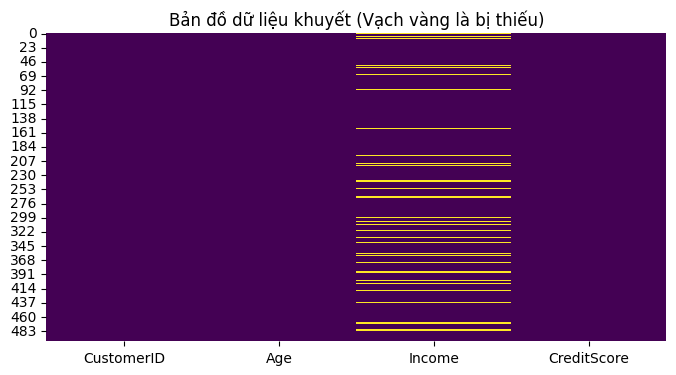

In [2]:
# Kiểm tra tổng quan
print("\nThông tin dữ liệu:")
print(df.info())

# Thống kê mô tả (Chú ý min, max để phát hiện vô lý)
print("\nThống kê mô tả:")
print(df.describe()) 
# Nhận xét: Max Age = 200 -> Vô lý. Min Age = -5 -> Vô lý.

# Trực quan hóa dữ liệu thiếu bằng Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Bản đồ dữ liệu khuyết (Vạch vàng là bị thiếu)')
plt.show()

### Bước 2: Xử lý Dữ liệu khuyết (Imputation)
Với biến định lượng (như Income), ta thường điền bằng **Mean** (nếu phân phối chuẩn) hoặc **Median** (nếu có outlier làm lệch mean).

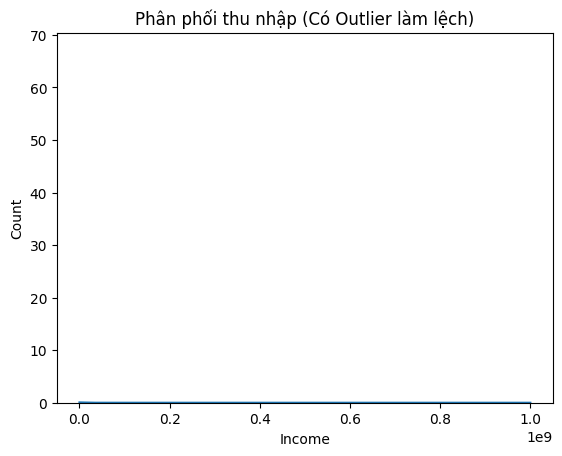

Đã điền 50 giá trị thiếu bằng Median: 50862.08


In [3]:
# Kiểm tra phân phối Income trước khi quyết định
sns.histplot(df['Income'].dropna(), kde=True)
plt.title('Phân phối thu nhập (Có Outlier làm lệch)')
plt.show()

# Vì có Outlier cực lớn (Tỷ phú), dùng Mean sẽ bị sai lệch. Nên dùng Median.
income_median = df['Income'].median()
df['Income_Cleaned'] = df['Income'].fillna(income_median)

print(f"Đã điền {df['Income'].isnull().sum()} giá trị thiếu bằng Median: {income_median:.2f}")

### Bước 3: Xử lý Giá trị ngoại lai (Outliers)
Sử dụng phương pháp **Z-score**. Nếu giá trị nằm ngoài $\pm 3$ độ lệch chuẩn ($\|Z\| > 3$), coi là outlier.

In [4]:
# Tính Z-score cho cột Age
df['Age_Zscore'] = stats.zscore(df['Age'])

# Lọc ra các dòng outlier
outliers = df[np.abs(df['Age_Zscore']) > 3]
print("Phát hiện các outlier tuổi:")
print(outliers[['CustomerID', 'Age', 'Age_Zscore']])

# Xử lý: Loại bỏ (Trim) hoặc Sửa (Winsorize)
# Ở đây ta chọn cách loại bỏ các dòng vô lý (Age < 0 hoặc Age > 100)
df_clean = df[(df['Age'] > 0) & (df['Age'] < 100)].copy()

# Đồng thời loại bỏ luôn ông Tỷ phú ở cột Income (làm thủ công hoặc dùng IQR)
df_clean = df_clean[df_clean['Income'] < 1000000]

print(f"\nKích thước dữ liệu sau khi làm sạch: {df_clean.shape}")

Phát hiện các outlier tuổi:
     CustomerID  Age  Age_Zscore
0             1  200   13.303125
1             2   -5   -3.203591
209         210   73    3.077013

Kích thước dữ liệu sau khi làm sạch: (448, 6)


### Bước 4: Kiểm tra tính chuẩn (Normality Test)
Dùng kiểm định **Shapiro-Wilk** và biểu đồ **Q-Q Plot**.

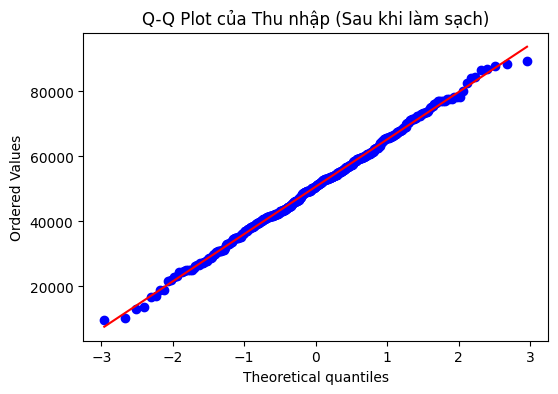

Shapiro-Wilk Test: Statistic=0.9976, p-value=0.7583
Kết luận: Dữ liệu có phân phối Chuẩn.


In [5]:
# Vẽ Q-Q Plot cho cột Income đã làm sạch
plt.figure(figsize=(6, 4))
stats.probplot(df_clean['Income_Cleaned'], dist="norm", plot=plt)
plt.title('Q-Q Plot của Thu nhập (Sau khi làm sạch)')
plt.show()

# Kiểm định thống kê Shapiro-Wilk
# H0: Dữ liệu tuân theo phân phối chuẩn
# Nếu p-value < 0.05 -> Bác bỏ H0 -> Dữ liệu KHÔNG chuẩn
stat, p_value = stats.shapiro(df_clean['Income_Cleaned'])
print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")

if p_value > 0.05:
    print("Kết luận: Dữ liệu có phân phối Chuẩn.")
else:
    print("Kết luận: Dữ liệu KHÔNG phân phối Chuẩn (cần chuyển đổi log hoặc box-cox nếu chạy hồi quy).")

## 2.4. Tổng kết và Bài tập

### Bàn luận quản trị
Trong thực tế, việc xóa dữ liệu (như xóa các dòng thiếu Income) là một sự đánh đổi. 
* Nếu bạn xóa quá nhiều: Mẫu sẽ nhỏ lại, mất độ tin cậy.
* Nếu bạn thay thế (Imputation) sai cách: Bạn đang "bịa" ra dữ liệu và làm sai lệch mối quan hệ thực tế.
**Lời khuyên:** Luôn giữ lại file gốc (Raw Data) và ghi lại (log) mọi bước xử lý bạn đã làm.

### Bài tập thực hành
1.  Truy cập bộ dữ liệu **Titanic** nổi tiếng trên Kaggle hoặc thư viện seaborn (`sns.load_dataset('titanic')`).
2.  Biến **Age** của hành khách bị thiếu khoảng 20%. Hãy thử lấp đầy nó bằng 2 cách và so sánh biểu đồ phân phối kết quả:
    * Cách 1: Điền bằng trung bình cộng (Mean).
    * Cách 2: Điền bằng trung bình theo nhóm danh xưng (Ví dụ: Mr. điền theo mean của Mr., Mrs. điền theo mean của Mrs.).